# Text cleaning and Data splitting

In [31]:
from gensim.models import Phrases
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np
import nltk
import string
import re
from collections import Counter

# local
from text_cleaner import Cleaner

seed=2020

In [32]:
dir_in = '../../data/raw/label-smoothing/'
dir_out = '../../data/clean/label-smoothing/'
dataset_name = '+gop_rel_only'

df = pd.read_csv(dir_in + dataset_name + '.csv', encoding = "ISO-8859-1")
df.head(2)

,candidate,candidate:confidence,relevant_yn,relevant_yn:confidence,sentiment,sentiment:confidence,subject_matter,subject_matter:confidence,candidate_gold,name,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0,NaN,I_Am_Kenzi,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,8/7/15 9:54,6.296970e+17,NaN,Quito
1,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0,NaN,PeacefulQuest,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,8/7/15 9:54,6.296970e+17,NaN,NaN


Text(0, 0.5, 'Counts')

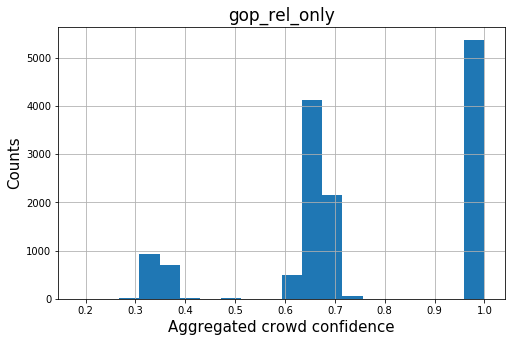

In [33]:
ax= df['sentiment:confidence'].hist(bins=20, figsize=(8,5))
ax.set_title('gop_rel_only', fontsize=17)
ax.set_xlabel('Aggregated crowd confidence', fontsize=15)
ax.set_ylabel('Counts', fontsize=15)

## Transform data

In [34]:
print(len(df))

13871


In [35]:
# df = df[(df['_golden'] == False) & (df['sentiment'] != "Neutral") & (df['sentiment:confidence'] > 0.6)]
df = df[df['sentiment:confidence'] > 0.6]
print(len(df))

12209


### Plot Classes distribution

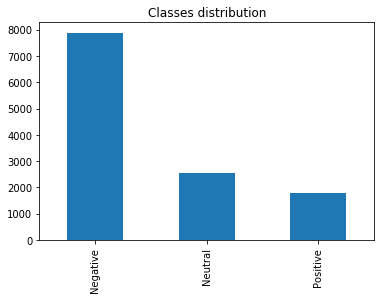

In [36]:
df['sentiment'].value_counts().plot.bar(title='Classes distribution')

### Assign labels to categiry column

In [37]:
def f(x):
    if x =='Negative': return 0
    if x =='Positive': return 1
    if x == 'Neutral': return 2
df['label'] = df['sentiment'].apply(f)
# df['text'] = df['headline'] +'. ' + df['text']

### Clean data basics and stemming

In [38]:
cln_stem = Cleaner(with_stemming=True)
data_cleaned_stem = []
for _, row in df.iterrows():
    text = row['text']
    label = row['label']
    if label == 0:
        conf0 = row['sentiment:confidence']
        conf1 = (1 - conf0) / 2
        conf2 = (1 - conf0) / 2
    if label == 1:
        conf1 = row['sentiment:confidence']
        conf0 = (1 - conf1) / 2
        conf2 = (1 - conf1) / 2
    if label == 2:
        conf2 = row['sentiment:confidence']
        conf0 = (1 - conf2) / 2
        conf1 = (1 - conf2) / 2
    
#     data_cleaned_stem.append([cln_stem.clean_text(text), label, conf0, conf1, conf2])
    data_cleaned_stem.append([text, label, conf0, conf1, conf2])

df = pd.DataFrame(data_cleaned_stem, columns=['text', 'label', 'conf0', 'conf1', 'conf2'])

df.head(2)

### Train Test Val splitting

In [41]:
from sklearn.utils import shuffle

# Test
idx_neg = np.where(df.label.values == 0)[0]
idx_pos = np.where(df.label.values == 1)[0]
idx_nut = np.where(df.label.values == 2)[0]
np.random.seed(seed=2020)
test_idx_neg = np.random.choice(idx_neg, size=180, replace=False)
np.random.seed(seed=2020)
test_idx_pos = np.random.choice(idx_pos, size=180, replace=False)
np.random.seed(seed=2020)
test_idx_nut = np.random.choice(idx_nut, size=180, replace=False)
test_indx = np.concatenate((test_idx_neg, test_idx_pos, test_idx_nut))
test_indx = shuffle(test_indx, random_state=seed)
df_test = df.ix[test_indx]


# Validation
df.drop(test_indx).reset_index(drop=True)
idx_neg = np.where(df.label.values == 0)[0]
idx_pos = np.where(df.label.values == 1)[0]
idx_nut = np.where(df.label.values == 2)[0]

np.random.seed(seed=2020)
val_idx_neg = np.random.choice(idx_neg, size=180, replace=False)
np.random.seed(seed=2020)
val_idx_pos = np.random.choice(idx_pos, size=180, replace=False)
np.random.seed(seed=2020)
val_idx_nut = np.random.choice(idx_nut, size=180, replace=False)
val_indx = np.concatenate((val_idx_neg, val_idx_pos, val_idx_nut))
val_indx = shuffle(val_indx, random_state=seed)
df_val = df.ix[val_indx]

df_train = df.drop(val_indx).reset_index(drop=True)


# save data
df_train.to_csv(dir_out+ 'train_' + dataset_name +'_mclass.csv', index=False)
df_val.to_csv(dir_out+ 'val_' + dataset_name +'_mclass.csv', index=False)
df_test.to_csv(dir_out+ 'test_' + dataset_name +'_mclass.csv', index=False)

/Users/evgeny/Documents/wonderful_programming/crowd_ai_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app
/Users/evgeny/Documents/wonderful_programming/crowd_ai_env/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


In [28]:
df_val.label.value_counts()

2    180
1    180
0    180
Name: label, dtype: int64

### Train stat

In [51]:
print('total: ', len(df_train.label))
print("counts:")
print(df_train.label.value_counts())
print("%:")
print(df_train.label.value_counts()/len(df_train.label))



total:  11669
counts:
0    7699
2    2349
1    1621
Name: label, dtype: int64
%:
0    0.659782
2    0.201303
1    0.138915
Name: label, dtype: float64
